## Analysis of cluster data produced by mPIXdaq
                                                    Günter Quast, Aug. 2025

This code analyzes the properties of pixel clusters derived from miniPIX frames 
uning the class `frameAnalyzer` of the Python package *mpixdaq*. The class 
is shown here:

``` 
Class frameAnalyzer:
    Analyze frame data

    - find clusters using scipy.ndimage.label()
    - compute cluster energies
    - compute position and covariance matrix of x- and y-coordinates
    - compute covariance matrix of the energy distribution
    - analyze cluster shape (using eigenvalues of covariance matrix)
    - construct a tuple with cluster properties

    Note: this algorithm only works if clusters do not overlap!

    Args:

    - 2d-frame from the miniPIX

    Returns:

    - n_pixels: number of pixels with energy > 0
    - n_clusters: number of clusters
    - n_cpixels: number of pixels per cluster
    - circularity: circularity per cluster (0. for linear, 1. for circular)
    - cluster_energies: energy per cluster

    - self.clusters is a tuple with properties per cluster with mean of x and y coordinates,
      number of pixels, energy, eigenvalues of covariance matrix and orientation ([-pi/2, pi/2])
      and the minimal and maximal eigenvalues of the covariance matrix of the energy distribution:
      format  ( (x, y), n_pix, energy, (var_mx, var_mn), angle, (xEm, yEm), (varE_mx, varE_mn) )
```

These proberties per cluster or single, isolated pixel are exported to a *.csv* file with header   
   **x_mean** **y_mean** **n_pix** **energy** **var_mx** **var_mn** **angle** **xE_mean** **yE_mean** **varE_mx**  **varE_mn**  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LogNorm

#### Import data and add derived quantities

In [2]:
# import data in a pandas data frame
#df = pd.read_csv("data/BlackForestStone_clusters.csv.gz")
#df = pd.read_csv("data/BFstone_clusters.csv.gz")
df = pd.read_csv("BFstone_clusters.csv")

# add derived quantities
#  - circularity defined as the ratio of the smaller and the larger eigenvalue 
#    of the covariance matrix of the pixels in a cluster
df['circularity'] = df['var_mn'] / np.maximum(df['var_mx'].to_numpy(), 0.001)

# the maximum variance of n pixels on a straight line is npix**2/12
df['linearity'] = np.minimum(12.*df['var_mx'].to_numpy()/((1.+np.sin(2.*df['angle'].to_numpy())**2) * df['n_pix'].to_numpy()**2), 3.)

# show data
display(df)

,time,x_mean,y_mean,n_pix,energy,var_mx,var_mn,angle,xE_mean,yE_mean,varE_mx,varE_mn,circularity,linearity
0,0.000,115.50,33.50,4,118.0,0.33,0.33,0.00,115.77,33.84,0.232,0.080,1.000000,0.247500
1,0.178,75.80,140.07,15,269.0,12.31,0.21,-0.18,75.82,139.07,10.921,0.147,0.017059,0.584054
2,0.178,91.20,168.80,5,93.0,1.25,0.15,0.79,91.05,168.65,0.424,0.119,0.120000,0.300013
3,0.354,26.00,41.29,7,278.0,1.68,0.23,0.58,25.68,41.06,0.822,0.202,0.136905,0.223538
4,0.354,64.50,110.00,2,58.0,0.50,0.00,1.57,64.60,110.00,0.239,-0.000,0.000000,1.499996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5198,1253.944,143.00,172.50,4,84.0,1.67,0.00,0.00,143.00,172.35,0.821,-0.000,0.000000,1.252500
5199,1253.944,200.00,187.00,9,158.0,2.75,0.25,0.32,200.06,187.50,1.531,0.120,0.090909,0.300306
5200,1254.127,95.67,129.83,12,389.0,6.54,0.40,0.70,95.41,129.35,6.130,0.340,0.061162,0.276494
5201,1254.127,98.84,109.16,25,444.0,37.02,0.43,-0.47,96.91,112.31,18.779,0.555,0.011615,0.430218


#### Produce an overview of the distributions of the input variables

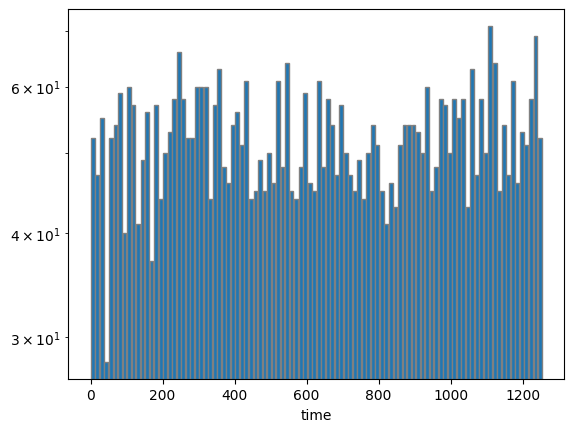

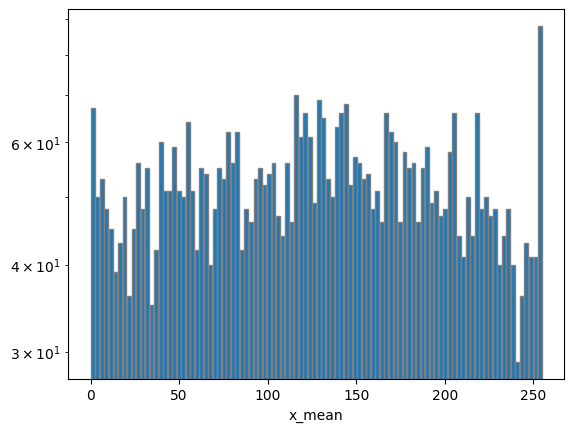

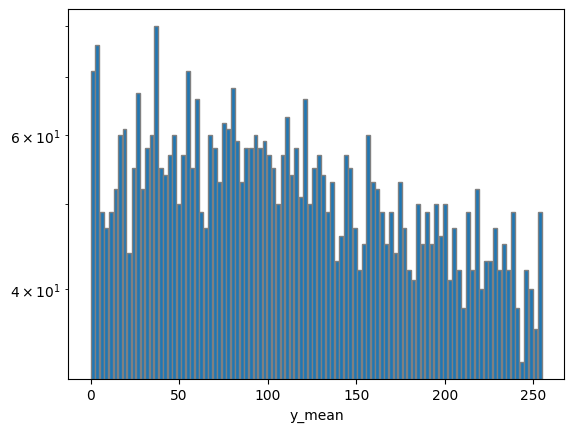

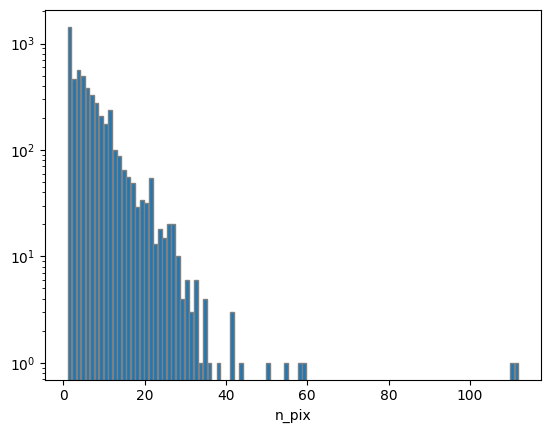

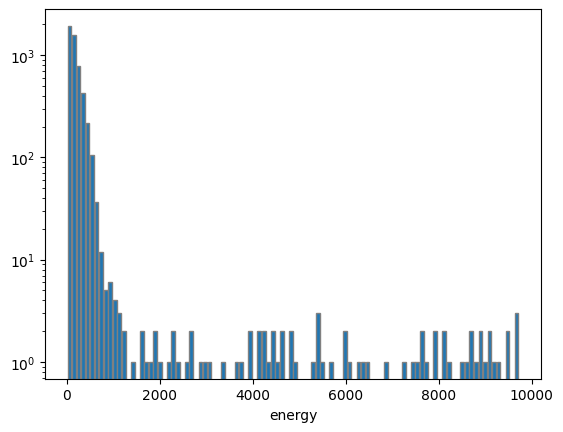

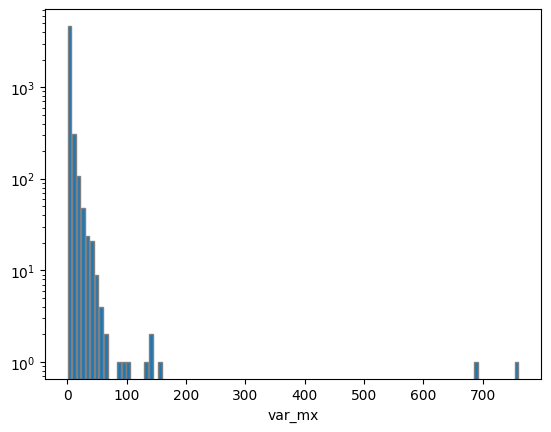

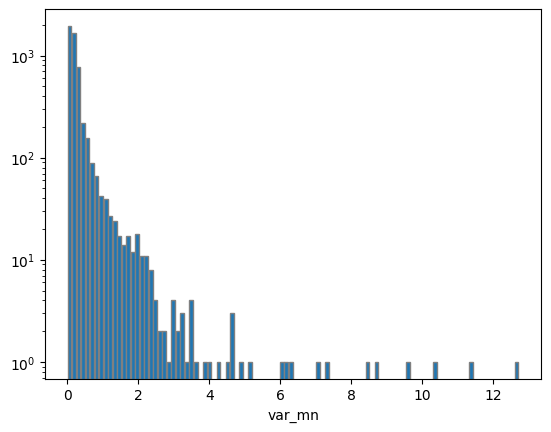

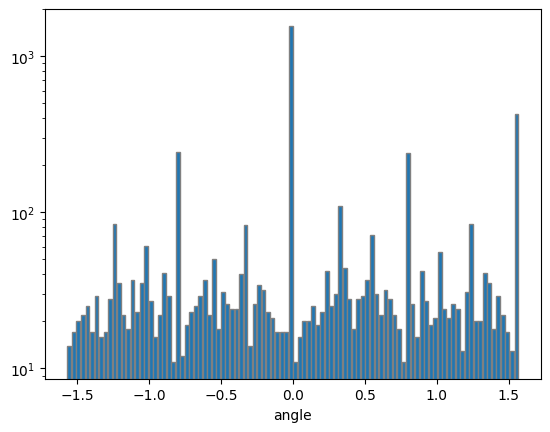

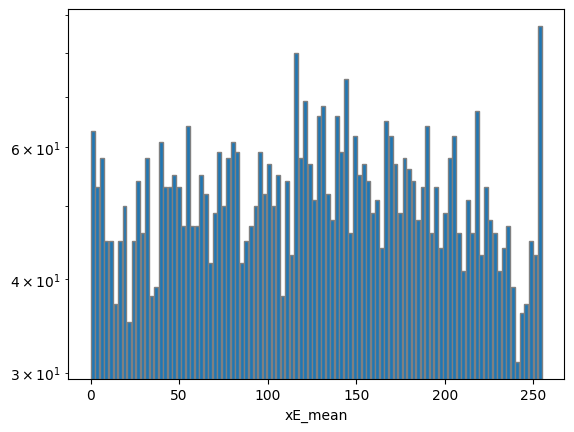

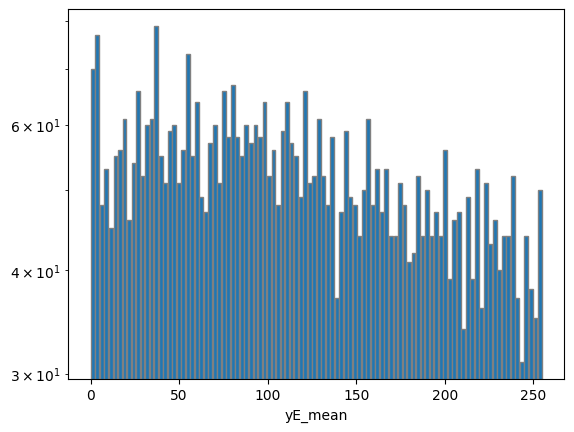

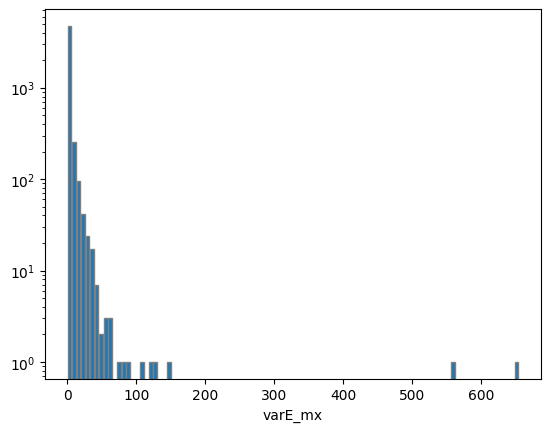

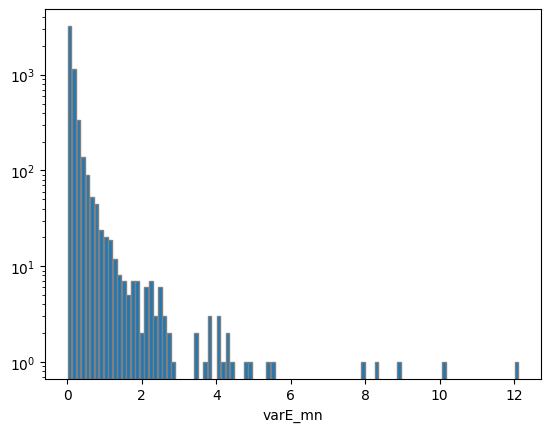

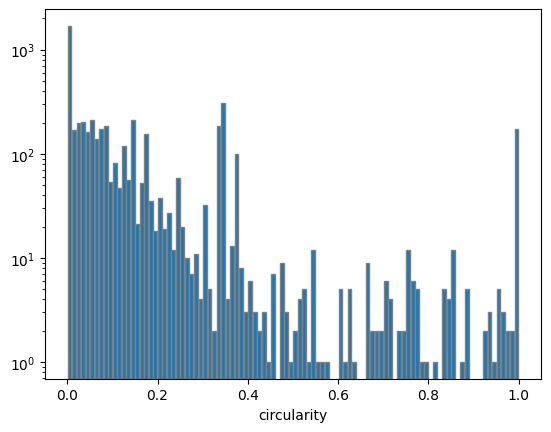

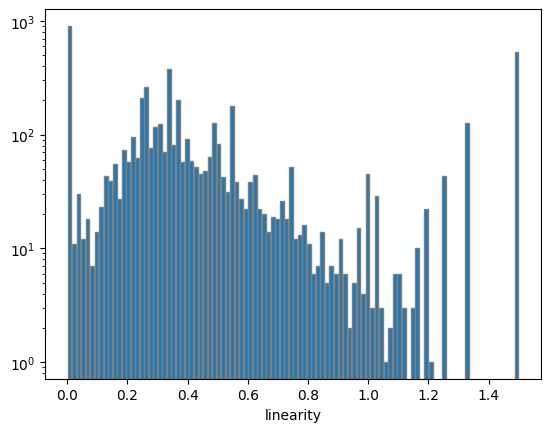

In [3]:
def plt_keys(df):
    for key in df.keys():
        _ = plt.hist(df[key][df[key] != np.nan], bins=100, rwidth=0.85, edgecolor='grey')
        plt.yscale("log")
        plt.xlabel(key)
        plt.show()

plt_keys(df)

#### Spacial distribution of clusters

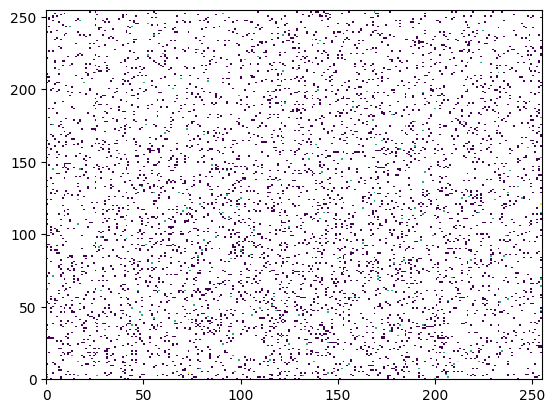

In [4]:
_ = plt.hist2d(df['x_mean'], df['y_mean'], bins=(256, 256), norm=LogNorm())
plt.show()

#### 2d plots for different circularities

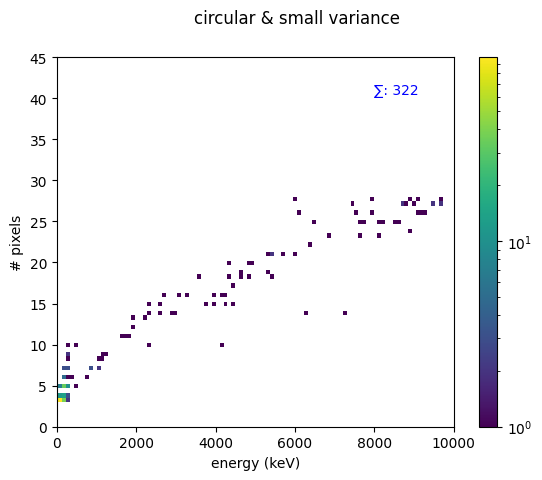

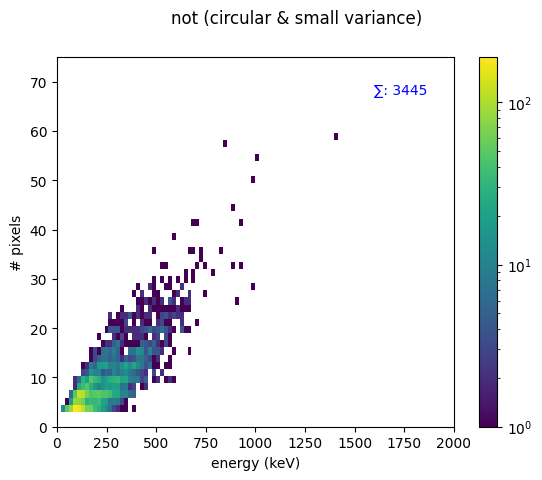

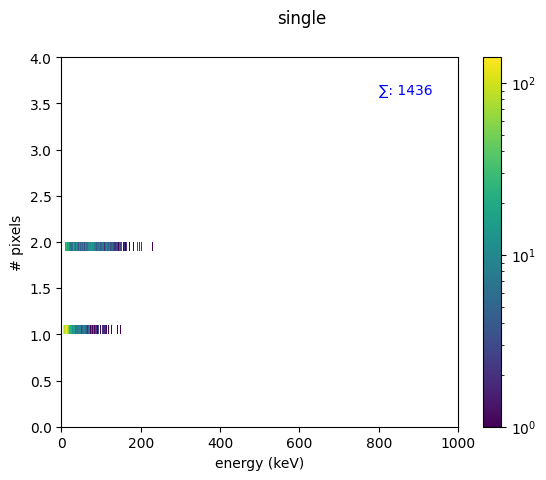

In [5]:
circularity_cut = 0.3
is_circular = df['circularity'] >= circularity_cut
is_linear = df['circularity'] < circularity_cut
is_single = df['n_pix'] <= 2
has_small_varEmx = df['varE_mx'] / df['var_mx'] <= 0.4

is_alpha = is_circular & has_small_varEmx

_ = plt.hist2d(df['energy'][is_alpha], df['n_pix'][is_alpha], bins = (100, 45), norm=LogNorm())
#_ = plt.hist2d(df['energy'], df['n_pix'], bins = (100, 55), norm=LogNorm())
plt.xlim(0, 10000)
plt.ylim(0, 45)
plt.suptitle("circular & small variance")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_alpha.sum()}", transform=_ax.transAxes, color='b') 
plt.show()

_msk = ~is_alpha & ~is_single
_ = plt.hist2d(df['energy'][_msk], df['n_pix'][_msk], bins = (100, 75), norm=LogNorm())
plt.xlim(0, 2000)
plt.ylim(0, 75)
plt.suptitle("not (circular & small variance)")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {_msk.sum()}", transform=_ax.transAxes, color='b') 
plt.show()

_ = plt.hist2d(df['energy'][is_single], df['n_pix'][is_single], bins = (100,10), norm=LogNorm()) 
plt.xlim(0,1000)
plt.ylim(0, 4)
plt.suptitle("single")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_single.sum()}", transform=_ax.transAxes, color='b') 
plt.show()


#### Discussion

These scatter plots show a very clear structure arising from the propeties of the detected particles.

  - alpha particles produce small, round clusters and deposit all of their energy in a small volume
  - beta particles produce long tracks in the material
  - photons produce - typically low-energy - electrons leading to signatures with very few or
    even isolated pixels

Note that some of the long tracks may have a significant "circularity" if they are bent !